In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

seed = 0

In [3]:
score_data = pd.read_csv('./ratings.dat', names=['user_id', 'movie_id', 'rating', 'timestamp'],
                        sep="::", engine='python')

# movie item lists in score data not equal to movies_extrainfos

In [4]:
# popular/tail/niche items (top/bottom 20% popularity)
i_sorted = score_data.movie_id.value_counts().index
total_items = i_sorted.values
pop_items = i_sorted[:int(len(i_sorted)*0.2)].values
tail_items = i_sorted[int(len(i_sorted)*0.2):].values
niche_items = i_sorted[int(len(i_sorted)*0.8):].values

# cold_users
n_users = len(score_data.user_id.unique())
heavy_users = score_data.user_id.value_counts().head(int(n_users*0.2)).index.values
warm_users = score_data.user_id.value_counts().head(int(n_users*0.8)).index.values
cold_users = score_data.user_id.value_counts().tail(int(n_users*0.2)).index.values

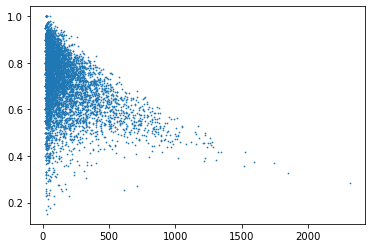

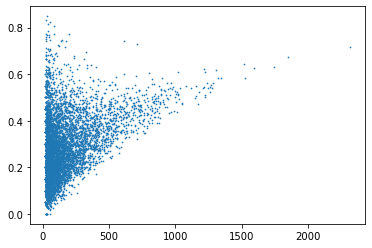

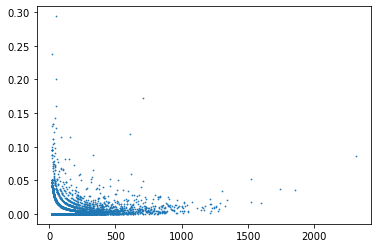

In [5]:
# ratio of pop and tail items for warm-/cold-start users
score_data['pop'] = score_data['movie_id'].apply(lambda x: 1 if x in pop_items else 0)
score_data['tail'] = score_data['movie_id'].apply(lambda x: 1 if x in tail_items else 0)
score_data['niche'] = score_data['movie_id'].apply(lambda x: 1 if x in niche_items else 0)

user_pop_cnt = score_data.groupby(['user_id'])['pop']
user_tail_cnt = score_data.groupby(['user_id'])['tail']
user_niche_cnt = score_data.groupby(['user_id'])['niche']

plt.scatter(score_data.groupby(['user_id']).movie_id.count(), user_pop_cnt.sum()/user_pop_cnt.count(), s=0.5) # 비율 
plt.show()
plt.scatter(score_data.groupby(['user_id']).movie_id.count(), user_tail_cnt.sum()/user_tail_cnt.count(), s=0.5) # 비율 
plt.show()
plt.scatter(score_data.groupby(['user_id']).movie_id.count(), user_niche_cnt.sum()/user_niche_cnt.count(), s=0.5) # 비율 
plt.show()

In [6]:
np.random.seed(seed)
warm_user_test = np.random.choice(warm_users, int(len(warm_users)*0.25), replace=False)
warm_user_train = np.setdiff1d(warm_users, warm_user_test)

In [7]:
# new_user
cold_u_score = score_data[score_data['user_id'].apply(lambda x: True if x in cold_users else False)]
warm_u_score_train = score_data[score_data['user_id'].apply(lambda x: True if x in warm_user_train else False)]
warm_u_score_test = score_data[score_data['user_id'].apply(lambda x: True if x in warm_user_test else False)]

# no overlapping users
print(set(warm_u_score_train.index.values).intersection(set(warm_u_score_test.index.values)))
print(set(cold_u_score.index.values).intersection(set(warm_u_score_test.index.values)))
print(set(warm_u_score_train.index.values).intersection(set(cold_u_score.index.values)))

set()
set()
set()


In [8]:
print(len(warm_u_score_test.user_id.unique()))
print(len(warm_u_score_train.user_id.unique()))
print(len(cold_u_score.user_id.unique()))

1208
3624
1208


In [9]:
import json
with open('warm_state.json', 'w') as f:
    json.dump(warm_u_score_train.groupby(['user_id']).movie_id.apply(list).to_dict(), f)
    
with open('warm_state_y.json', 'w') as f:
    json.dump(warm_u_score_train.groupby(['user_id']).rating.apply(list).to_dict(), f)
    
with open('user_old_state.json', 'w') as f:
    json.dump(warm_u_score_test.groupby(['user_id']).movie_id.apply(list).to_dict(), f)

with open('user_old_state_y.json', 'w') as f:
    json.dump(warm_u_score_test.groupby(['user_id']).rating.apply(list).to_dict(), f)
    
with open('user_cold_state.json', 'w') as f:
    json.dump(cold_u_score.groupby(['user_id']).movie_id.apply(list).to_dict(), f)
    
with open('user_cold_state_y.json', 'w') as f:
    json.dump(cold_u_score.groupby(['user_id']).rating.apply(list).to_dict(), f)

In [ ]:
import pickle
user_clicked_set = score_data.groupby(['user_id'])['movie_id'].unique().apply(list).to_dict()
pickle.dump(user_clicked_set, open('./user_clicked_set.pkl', 'wb'))

# Evaluation 

In [9]:
import torch
from typing import NoReturn, List, Dict
def evaluate_method(predictions: np.ndarray, topk: list=[5, 10, 20], metrics: list=["HR", "NDCG"]) -> Dict[str, float]:
    """
    :param predictions: (-1, n_candidates) shape, the first column is the score for ground-truth item
    :param topk: top-K values list
    :param metrics: metrics string list
    :return: a result dict, the keys are metrics@topk
    """
    evaluations = dict()
    sort_idx = (-predictions).argsort(axis=1)
    gt_rank = np.argwhere(sort_idx == 0)[:, 1] + 1
    #print(gt_rank.shape)
    for k in topk:
        hit = (gt_rank <= k)
        for metric in metrics:
            key = '{}@{}'.format(metric, k)
            if metric == 'HR':
                evaluations[key] = hit.mean().astype(np.float16)
            elif metric == 'NDCG':
                evaluations[key] = (hit / np.log2(gt_rank + 1)).mean().astype(np.float16)
            else:
                raise ValueError('Undefined evaluation metric: {}.'.format(metric))
    evaluations['n_items'] = gt_rank.shape
    return evaluations

def item_ratio(predictions: np.ndarray, item_idx: np.ndarray, anchor_list: np.array, topk: list=[10, 20, 50, 100]) -> Dict[str, float]:
    """
    :param predictions: (-1, n_candidates) shape, the first column is the score for ground-truth item
    :param anchor_list: list of item lists based on item popularity
    :param item_idx: item id list for each prediction
    """
    evaluations = dict()
    item_idx = item_idx.reshape(predictions.shape)
    sort_idx = (-predictions).argsort(axis=1)
    for k in topk:
        evaluations['top_'+str(k)] = np.isin(np.take_along_axis(item_idx,sort_idx, axis=1)[..., :k], anchor_list).mean(axis=-1).mean()
    return evaluations

def evaluate_method_items(predictions: torch.tensor, anchor_list:list, item_idx:torch.tensor, topk: list=[5, 10, 20], metrics: list=["HR", "NDCG"]) -> Dict[str, float]:
    """
    :param predictions: (-1, n_candidates) shape, the first column is the score for ground-truth item
    :param anchor_list: list of item lists based on item popularity
    :param item_idx: item id list for each prediction
    """
    item_pos = item_idx.view(-1,100)[:,0].numpy()
    total_items, pop_items, tail_items, niche_items = anchor_list
    predictions = predictions.view(-1,100).numpy()
    item_idx = item_idx.numpy()
    
    pred_pop = predictions[np.isin(item_pos, pop_items)]
    pred_tail = predictions[np.isin(item_pos, tail_items)]
    pred_niche = predictions[np.isin(item_pos, niche_items)]
    
    eval_total = evaluate_method(predictions)
    eval_pop = evaluate_method(pred_pop)
    eval_tail = evaluate_method(pred_tail)
    eval_niche = evaluate_method(pred_niche)
    
    ratio_total = item_ratio(predictions, item_idx, total_items)
    ratio_pop = item_ratio(predictions, item_idx, pop_items)
    ratio_tail = item_ratio(predictions, item_idx, tail_items)
    ratio_niche = item_ratio(predictions, item_idx, niche_items)
    
    df = pd.DataFrame(columns={**eval_total, **ratio_total}.keys())
    df = df.append(pd.DataFrame([{**eval_total, **ratio_total}], index=['total']))
    df = df.append(pd.DataFrame([{**eval_pop, **ratio_pop}], index=['pop']))
    df = df.append(pd.DataFrame([{**eval_tail, **ratio_tail}], index=['tail']))
    df = df.append(pd.DataFrame([{**eval_niche, **ratio_niche}], index=['niche']))
    
    
    return df


In [100]:
test_ways = ['10_old_user', '20_old_user', 'old_user']#,'new_user']
seeds = list(range(1,6))

In [112]:
anchor_list=[total_items, pop_items, tail_items, niche_items]
import torch
total_df = pd.DataFrame([])
for seed_tmp in seeds:
    for test_way in test_ways:
        predictions = torch.load('_'.join(['../../eval_result/', 'preds', test_way, str(seed_tmp), '.pt']))
        item_idx = torch.load('_'.join(['../../eval_result/', 'item_idx', test_way, str(seed_tmp), '.pt']))
        tmp_df = evaluate_method_items(predictions, anchor_list=anchor_list, item_idx=item_idx)
        tmp_df['seed'] = seed_tmp
        tmp_df['type'] = tmp_df.apply(lambda x: x.name, axis=1)
        tmp_df['test_way'] = test_way[:-5]
        tmp_df['index'] = tmp_df.apply(lambda x: '_'.join([test_way, str(seed_tmp),x.name]), axis=1)
        tmp_df['type_'] = tmp_df.apply(lambda x: '_'.join([test_way[:-5], x.name]), axis=1)
        total_df = total_df.append(tmp_df.set_index('index'))

In [113]:
total_df

,HR@5,NDCG@5,HR@10,NDCG@10,HR@20,NDCG@20,n_items,top_10,top_20,top_50,top_100,seed,type,test_way,type_
index,,,,,,,,,,,,,,,
10_old_user_1_total,0.367188,0.252686,0.532715,0.305908,0.726562,0.354980,"(12080,)",0.997873,0.997384,0.994740,0.952311,1,total,10_old,10_old_total
10_old_user_1_pop,0.488281,0.339600,0.675293,0.400146,0.857422,0.446289,"(8523,)",0.686813,0.548932,0.317493,0.169980,1,pop,10_old,10_old_pop
10_old_user_1_tail,0.077026,0.044037,0.190918,0.080383,0.413330,0.135986,"(3557,)",0.311060,0.448452,0.677247,0.782331,1,tail,10_old,10_old_tail
10_old_user_1_niche,0.017548,0.008774,0.070190,0.026810,0.105286,0.035278,"(57,)",0.011738,0.016759,0.041848,0.199862,1,niche,10_old,10_old_niche
20_old_user_1_total,0.407227,0.280762,0.578125,0.335938,0.760742,0.382080,"(12080,)",0.999412,0.999102,0.996331,0.952320,1,total,20_old,20_old_total
20_old_user_1_pop,0.539062,0.376953,0.730469,0.439209,0.896973,0.481445,"(8544,)",0.721068,0.572993,0.323674,0.169892,1,pop,20_old,20_old_pop
20_old_user_1_tail,0.089355,0.048492,0.209839,0.086670,0.431396,0.141968,"(3536,)",0.278344,0.426109,0.672657,0.782429,1,tail,20_old,20_old_tail
20_old_user_1_niche,0.000000,0.000000,0.044769,0.014786,0.104492,0.029617,"(67,)",0.004470,0.009052,0.033897,0.199897,1,niche,20_old,20_old_niche
old_user_1_total,0.443848,0.308350,0.616211,0.364014,0.787109,0.407227,"(12080,)",0.999619,0.999425,0.997763,0.952450,1,total,old,old_total


In [128]:
df_mean = total_df.groupby(['test_way', 'type']).mean().drop(['seed'], axis=1)

In [168]:
[True for col in df_mean.columns if 'top' in col]

[True, True, True, True]

In [180]:
ratio_cols = df_mean.columns[[True if 'top' in col else False for col in df_mean.columns]]
ax = None
for metric in ratio_cols:
    a = df_mean[metric].unstack(level=0)
    a.columns = ['_'.join([column, metric]) for column in a.columns]
    print(a)
    #ax = a.plot(ax=None)
    

       10_old_top_10  20_old_top_10  old_top_10
type                                           
niche       0.003416       0.001680    0.000949
pop         0.740661       0.763464    0.800838
tail        0.258866       0.236409    0.199079
total       0.999526       0.999873    0.999917
       10_old_top_20  20_old_top_20  old_top_20
type                                           
niche       0.006663       0.004296    0.002484
pop         0.584863       0.603168    0.631763
tail        0.414435       0.396573    0.368080
total       0.999299       0.999741    0.999844
       10_old_top_50  20_old_top_50  old_top_50
type                                           
niche       0.029991       0.025004    0.018755
pop         0.326429       0.330180    0.333817
tail        0.670732       0.667781    0.665052
total       0.997161       0.997962    0.998869
       10_old_top_100  20_old_top_100  old_top_100
type                                              
niche        0.199712        0.199

<AxesSubplot:xlabel='test_way'>

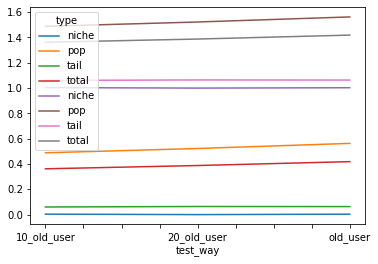

In [71]:
import matplotlib.pyplot as plt
ax = a.unstack().plot()
(a.unstack()+1).plot(ax=ax)


# correlation between history size and popularity bias

In [183]:
item_idx.shape

torch.Size([1208, 10, 100])

In [242]:
old_user = warm_u_score_test.groupby(['user_id']).movie_id.apply(list)
old_user_hist_len = warm_u_score_test.groupby(['user_id']).movie_id.count()

In [243]:
old_user_hist_len.values

array([129, 211,  70, ...,  48, 147,  60])

In [244]:
item_idx.shape

torch.Size([1208, 10, 100])

In [245]:
np.isin(np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1)[..., :k], pop_items).sum()

205328

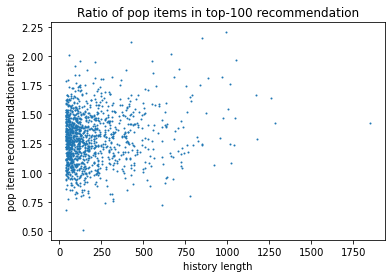

In [248]:
plt.scatter(old_user_hist_len, (evaluations['top_10']/evaluations['top_100']), s=1)
plt.xlabel("history length")
plt.ylabel("pop item recommendation ratio")
plt.title("Ratio of pop items in top-{} recommendation".format(str(k)))
plt.show()

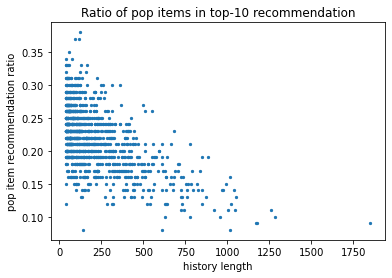

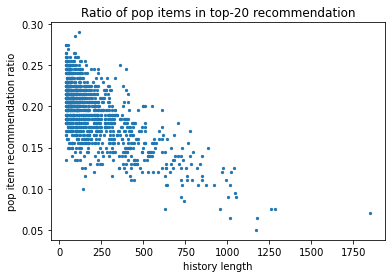

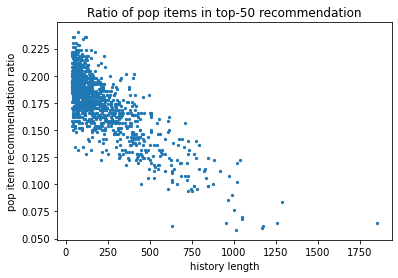

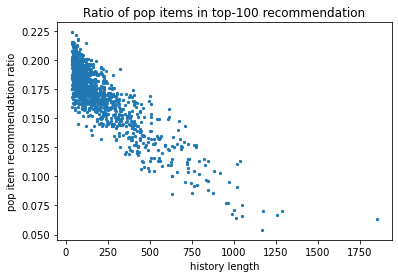

In [247]:
evaluations = dict()
item_idx = item_idx.reshape(predictions.shape)
sort_idx = (-predictions).argsort(axis=1)
for k in [10, 20, 50, 100]:    
    pop_ratio = np.isin(np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1)[..., :k], pop_items).reshape(len(old_user_hist_len), -1).mean(axis=-1)
    ax = plot_ratio(old_user_hist_len, pop_ratio, k)
    evaluations['top_'+str(k)] = pop_ratio

In [214]:
pop_ratio =  np.isin(np.take_along_axis(item_idx.numpy(),sort_idx.numpy(), axis=1)[..., :k], pop_items).reshape(len(old_user_hist_len), -1).mean(axis=-1)

In [230]:
def plot_ratio(old_user_hist_len, pop_ratio, k):
    plt.scatter(old_user_hist_len, pop_ratio, s=5)
    plt.xlabel("history length")
    plt.ylabel("pop item recommendation ratio")
    plt.title("Ratio of pop items in top-{} recommendation".format(str(k)))
    plt.show()

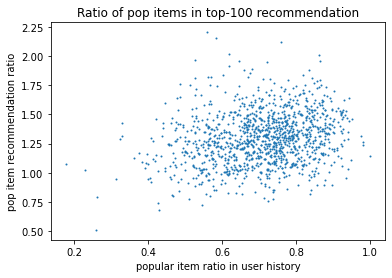

In [259]:
plt.scatter((user_pop_cnt.sum()/user_pop_cnt.count())[warm_u_score_test.user_id.unique()], (evaluations['top_10']/evaluations['top_100']), s=1)
plt.xlabel("popular item ratio in user history")
plt.ylabel("pop item recommendation ratio")
plt.title("Ratio of pop items in top-{} recommendation".format(str(k)))
plt.show()

# recommendation of popular items (of all items)

# genre-wise comparison